---

# CoverType

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_CoverType

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [3]:
def plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, real_scores, fake_scores, i, DATASET, show = False):
    num_epochs = len(d_losses)
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), d_losses[:num_epochs], label='d loss')
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    

    plt.plot(range(1, num_epochs + 1), d_losses_val[:num_epochs], '--', label='d loss val')

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_losses_{DATASET}.pdf')
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    
    plt.plot(range(1, num_epochs + 1), bce_losses[:num_epochs], label=r'$\log(D(y))$')    
    plt.plot(range(1, num_epochs + 1), rec_losses[:num_epochs], label=r'MSE')    

    plt.yscale('log')
    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_gen_loss_{DATASET}.pdf')  
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores[:num_epochs], label='real score')    

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_score_{DATASET}.pdf') 

def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)


def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1).to(device)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y


class Generator(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Generator, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), 
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.nf_out, self.nf_out * 2),
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_in)
        )

        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gumbel(self, logits, t):
        return gumbel_softmax(logits, t)

    def forward(self, x, text_l, selected_columnsTrain, index, t=1):
        enc = self.encoder(x)
        logits = self.decoder(enc)
        
        sampled_data = logits.clone()
        sampled_data[:, index] = self.sigmoid(logits[:, index])
        for name in text_l:
            sampled_data[:, selected_columnsTrain[name]] = self.gumbel(logits[:, selected_columnsTrain[name]], t)
        
        return logits, sampled_data
    
class Discriminator(nn.Module):

    def __init__(self, nc = 121, nf_out = 16, nout = 128):
        super(Discriminator, self).__init__()
        
        self.nc = nc
        self.nf_out = nf_out
        self.nout = nout
        
        self.main = nn.Sequential(
            # features extractor
            nn.Linear(self.nc, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout, self.nout * 2),
            nn.BatchNorm1d(self.nout * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout * 2, self.nout * 4),
            nn.BatchNorm1d(self.nout * 4, track_running_stats = False),
            nn.LeakyReLU(0.2),

            # classifier
            nn.Linear(self.nout * 4, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.ReLU(),

            nn.Linear(self.nout, self.nf_out * 4),
            nn.BatchNorm1d(self.nf_out * 4, track_running_stats = False),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 4, self.nf_out * 2),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out, 1),
            nn.Sigmoid()
        )
        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.main(x)
        return x.flatten()
    

class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
    
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss
    
    
class GeneratorLoss(nn.Module):
    def __init__(self, text_l, selected_columnsTrain, index):
        super(GeneratorLoss, self).__init__()
        
        self.text_l = text_l
        self.selected_columnsTrain = selected_columnsTrain
        self.index = index
        
        self.criterion = nn.BCELoss() 
        self.mse = nn.MSELoss(reduction = 'mean')
        self.cel = nn.CrossEntropyLoss()
    
    
    def reconstruction(self, true_data, sampled_data):
        g1 = self.mse(true_data[:, self.index], sampled_data[:, self.index])
        g2 = 0
        for name in self.text_l:
            y = true_data[:, self.selected_columnsTrain[name]]
            y_p = sampled_data[:, self.selected_columnsTrain[name]]
            g2 += self.mse(y_p, y)
        g2 /= len(self.text_l)
        return g1 + 0.5 * g2

    def forward(self, true_data, fake_preds, sampled_data, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        rec = self.reconstruction(true_data, sampled_data)
        
        return gamma*log_p_y + rec, log_p_y, rec
    
    
    
class AADNet(nn.Module):
    def __init__(self, device, selected_columns, discreteCol, index, nc):
        super(AADNet, self).__init__()
        self.device = device
        self.selected_columns = selected_columns
        self.discreteCol = discreteCol
        self.index = index
        self.nc = nc

        self.D = Discriminator(nc = self.nc).to(self.device)
        self.G = Generator(nf_in = self.nc).to(self.device)

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        
        self.d_loss = DiscriminatorLoss()
        self.g_loss = GeneratorLoss(self.discreteCol, self.selected_columns, self.index)
        
        self.temperature = 1
        self.anneal = 0.9995
        
        self.criterion = nn.BCELoss()
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        logits, sampled_data = self.G(true_data, self.discreteCol, self.selected_columns, self.index, self.temperature)
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, sampled_data = self.G(true_data, self.discreteCol, self.selected_columns, 
                                                        self.index, self.temperature)    
        fake_pred = self.D(sampled_data)

        gen_loss_batch, bce_loss, rec_loss = self.g_loss(true_data, fake_pred, sampled_data, self.temperature)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return gen_loss_batch, bce_loss, rec_loss

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal
            
            
    def evaluation(self, test_loader):
        self.D.eval()
        
        d_l = []
        ind = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
                d_loss_batch = self.criterion(y_pred, label)
                
            d_l.append(d_loss_batch.item())
        
        return np.mean(d_l)
    
    def predict(self, test_loader):
        self.D.eval()
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
            if i == 0:
                prediction = y_pred.cpu().round()
                y_true = label.cpu()
                yP = y_pred.cpu()
            else:
                prediction = torch.cat((prediction, y_pred.cpu().round()))
                y_true = torch.cat((y_true, label.cpu()))
                yP = torch.cat((yP, y_pred.cpu()))
                
            i += 1
            
        return prediction, y_true, yP
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
        
        
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        rec_losses = np.zeros(num_epochs)
        bce_losses = np.zeros(num_epochs)
        
        d_losses_val = np.zeros(num_epochs)
        precision_abn = np.zeros(num_epochs)
        recall_abn = np.zeros(num_epochs)
        
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                self.D.train()
                self.G.train()
                i = 0
                for batch in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)

                    ### Train autoencoder ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        g_loss, bce_loss, rec_loss = self.G_step(batch,step_count)

                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    
                    rec_losses[epoch] = rec_losses[epoch]*(i/(i+1.)) + rec_loss.item()*(1./(i+1.)) 
                    bce_losses[epoch] = bce_losses[epoch]*(i/(i+1.)) + bce_loss.item()*(1./(i+1.)) 
                    
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    i += 1
                
                dLossVal = self.evaluation(test_loader)
                
                d_losses_val[epoch] = dLossVal
               
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f} | d_loss_val: {:.4f}'
                              .format(epoch+1, num_epochs, d_losses[epoch], g_losses[epoch], bce_loss.item(), rec_losses[epoch], real_scores[epoch], fake_scores[epoch], d_losses_val[epoch]))
                sys.stdout.flush()
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return d_losses[:epoch], g_losses[:epoch],rec_losses[:epoch], bce_losses[:epoch], real_scores[:epoch], fake_scores[:epoch], d_losses_val[:epoch]




In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
FILE = 'covtype.data'

DATASET = 'CoverType'

PATH = os.path.join(WORK_SPACE, DATASET, FILE)

In [5]:
dataset = get_CoverType(PATH, seed, show=True)

530895 normal records, 50117 anormal records
We use 25059 anomalous records
-----------------------------------------------------------------------------------------
There are 444764 records in training set
Training set is composed by 444764 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 27797 records in validation set
Validation set is composed by 21532 normal records and 6265 abnormal records
-----------------------------------------------------------------------------------------
There are 83393 records in test set
Test set is composed by 64599 normal records and 18794 abnormal records


#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2027 (18.19, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 4.7097
[INFO] Training phase... Elapsed time: 6045 seconds



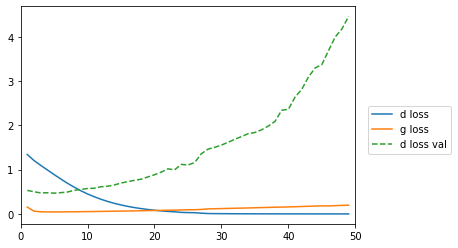

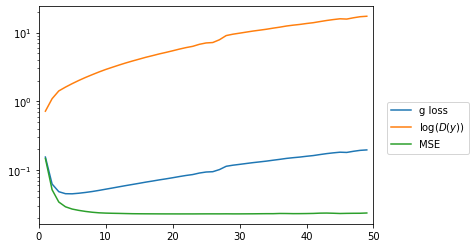

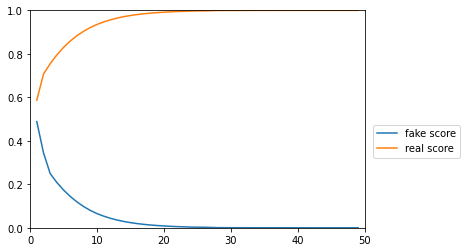

PR AUC: 0.84


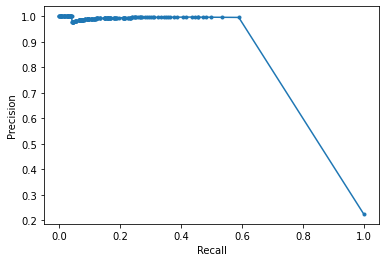

AUC: 0.79
Iteration: 2
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2078 (18.95, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.2611
[INFO] Training phase... Elapsed time: 6904 seconds



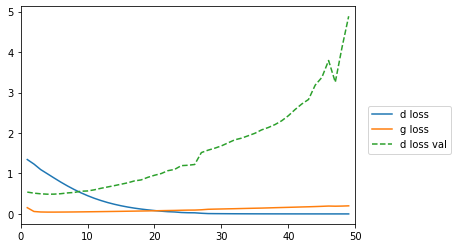

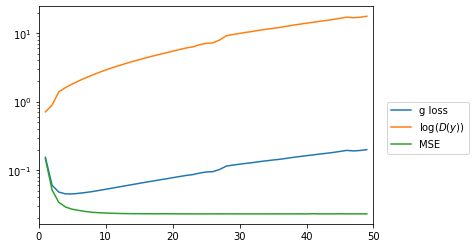

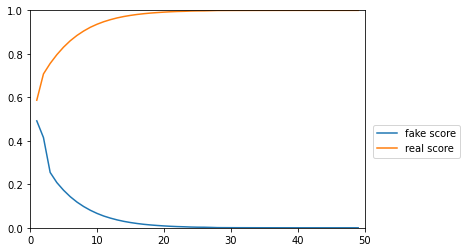

PR AUC: 0.78


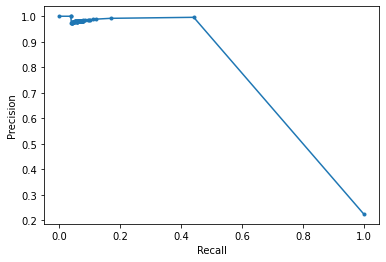

AUC: 0.72
Iteration: 3
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0003 | g_loss: 0.1783 (15.88, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.4357
[INFO] Training phase... Elapsed time: 7027 seconds



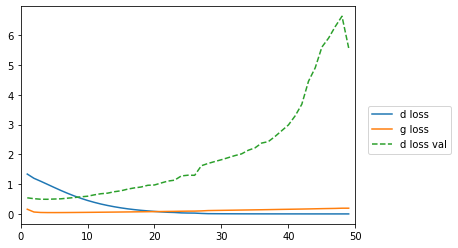

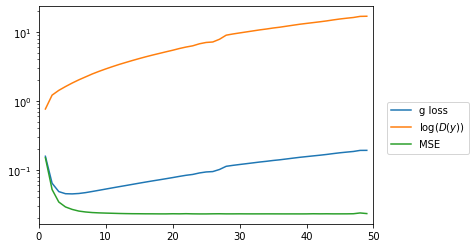

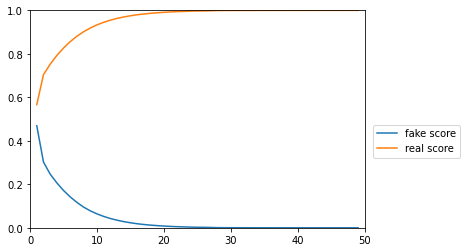

PR AUC: 0.78


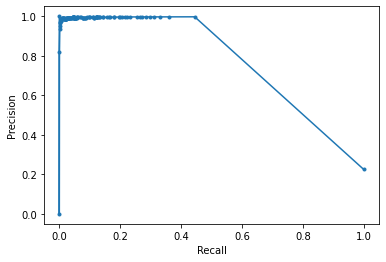

AUC: 0.72
Iteration: 4
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2110 (19.08, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.1316
[INFO] Training phase... Elapsed time: 7059 seconds



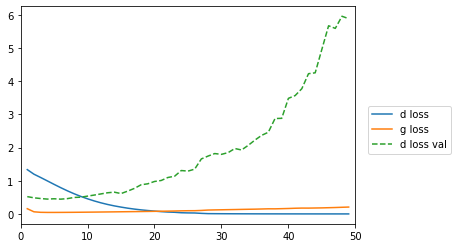

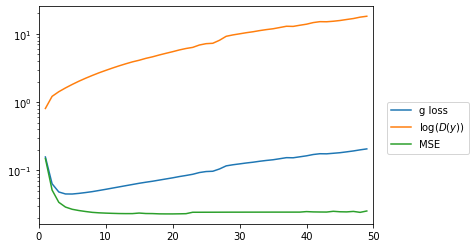

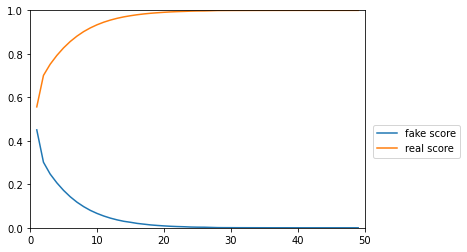

PR AUC: 0.69


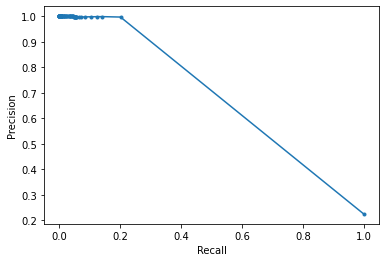

AUC: 0.60
Iteration: 5
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0017 | g_loss: 0.2292 (21.07, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.3235
[INFO] Training phase... Elapsed time: 7061 seconds



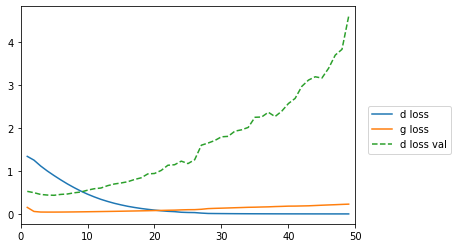

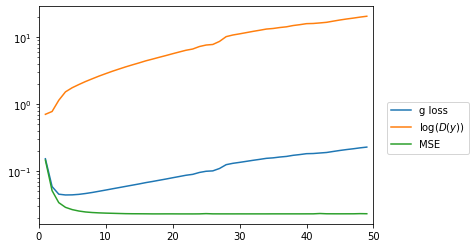

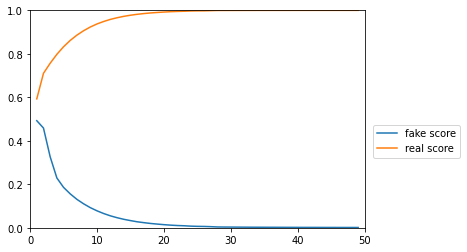

PR AUC: 0.78


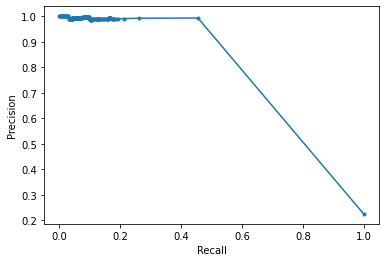

AUC: 0.73
Iteration: 6
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0003 | g_loss: 0.1969 (17.68, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.4711
[INFO] Training phase... Elapsed time: 7033 seconds



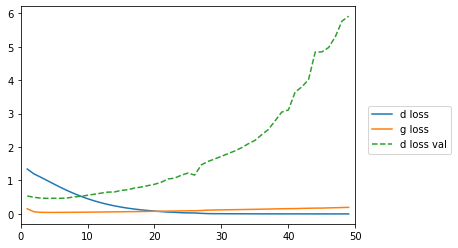

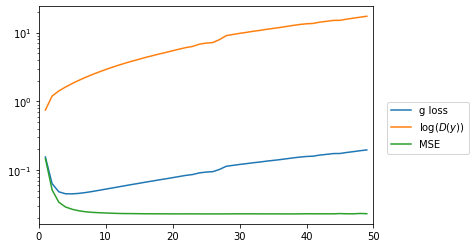

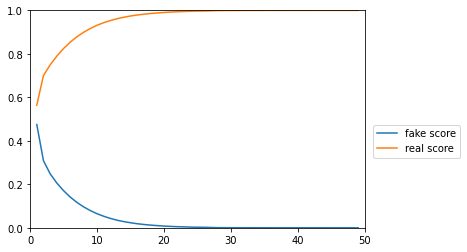

PR AUC: 0.78


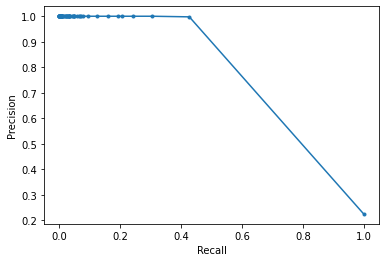

AUC: 0.71
Iteration: 7
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2207 (20.10, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 4.2388
[INFO] Training phase... Elapsed time: 7069 seconds



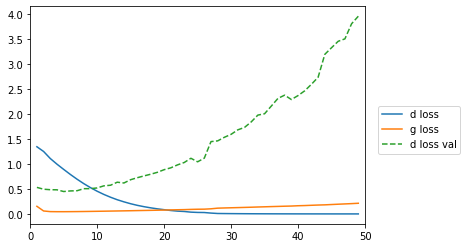

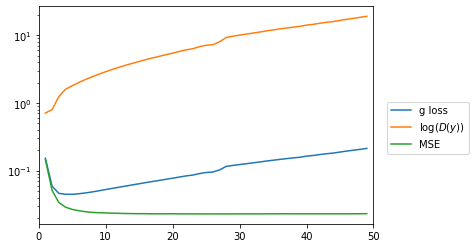

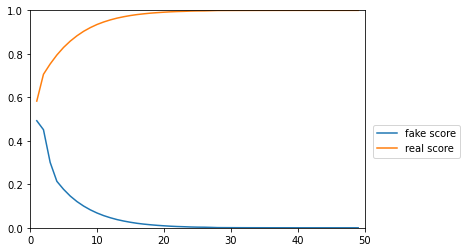

PR AUC: 0.90


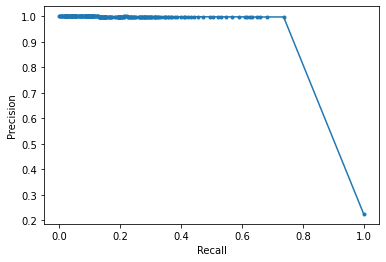

AUC: 0.87
Iteration: 8
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2053 (17.47, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.0167
[INFO] Training phase... Elapsed time: 6496 seconds



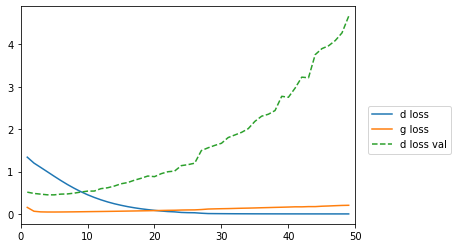

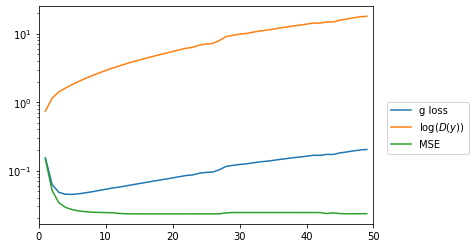

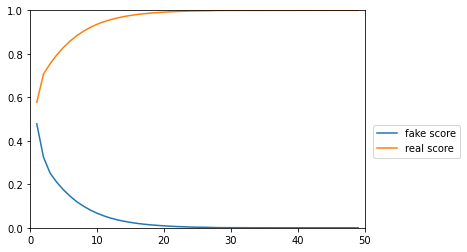

PR AUC: 0.71


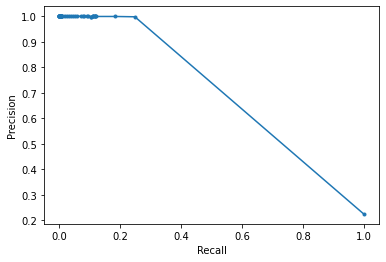

AUC: 0.62
Iteration: 9
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2066 (18.73, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 3.9566
[INFO] Training phase... Elapsed time: 5933 seconds



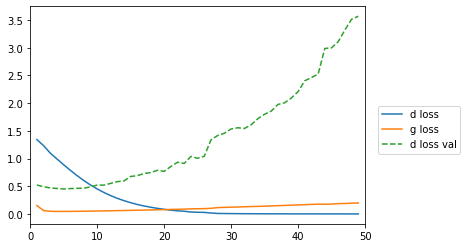

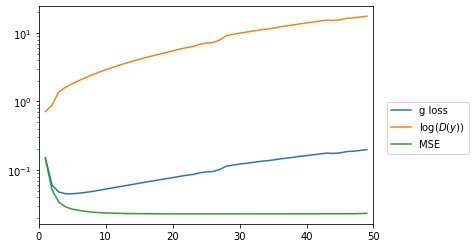

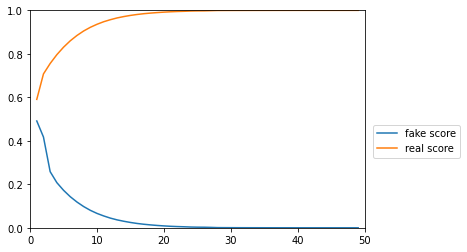

PR AUC: 0.92


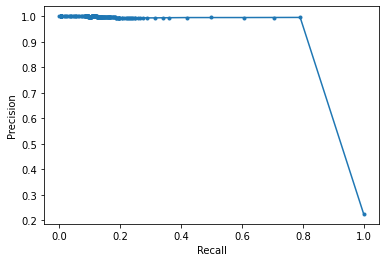

AUC: 0.90
Iteration: 10
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.1993 (17.62, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.1096
[INFO] Training phase... Elapsed time: 5931 seconds



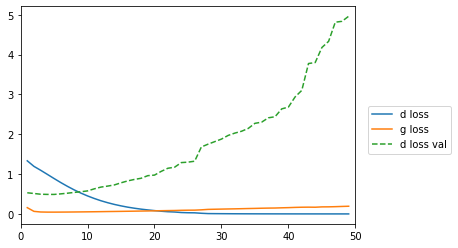

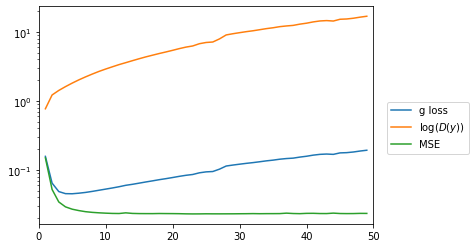

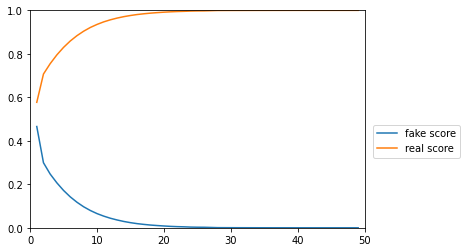

PR AUC: 0.79


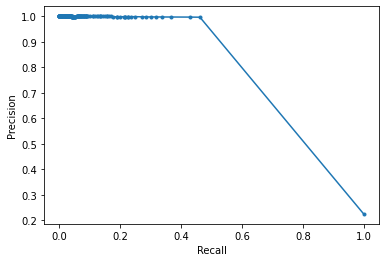

AUC: 0.73
Iteration: 11
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2171 (19.44, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.6550
[INFO] Training phase... Elapsed time: 5580 seconds



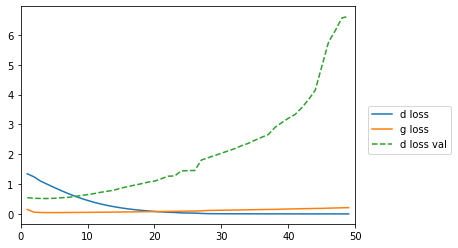

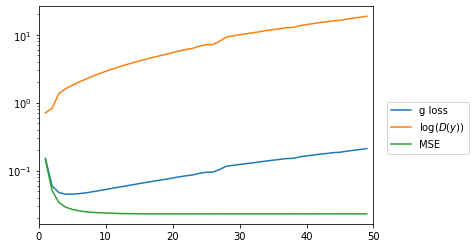

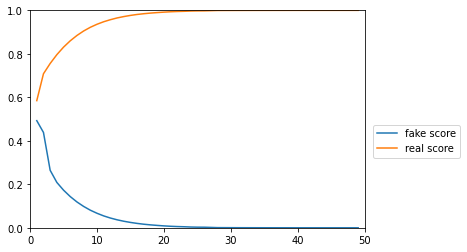

PR AUC: 0.64


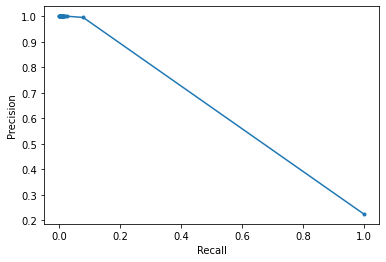

AUC: 0.54
Iteration: 12
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0017 | g_loss: 0.2274 (20.79, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.3055
[INFO] Training phase... Elapsed time: 5916 seconds



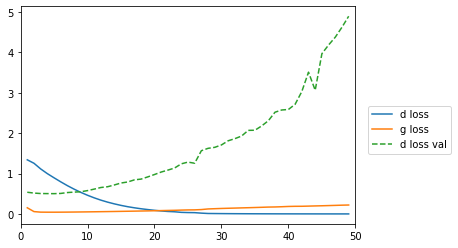

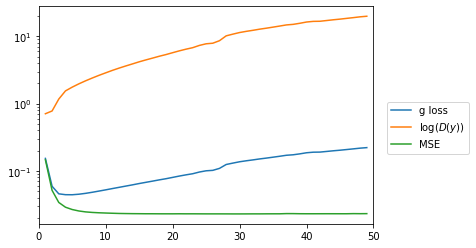

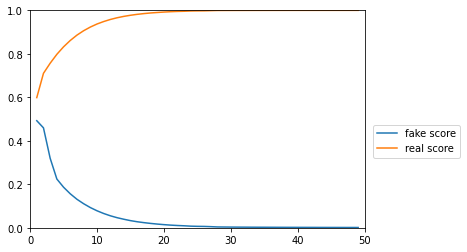

PR AUC: 0.79


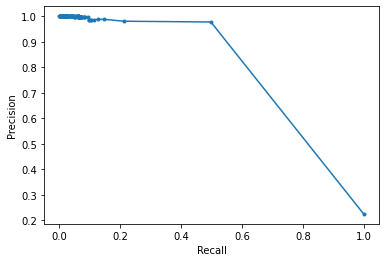

AUC: 0.75
Iteration: 13
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2107 (19.23, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.9793
[INFO] Training phase... Elapsed time: 5638 seconds



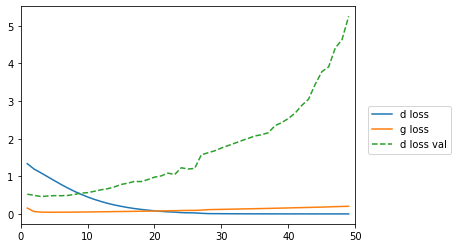

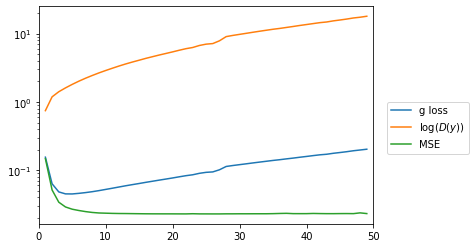

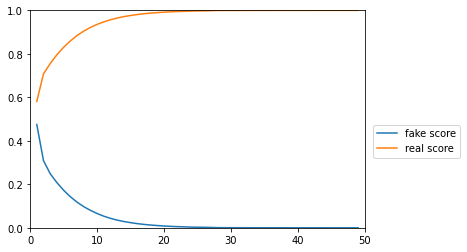

PR AUC: 0.68


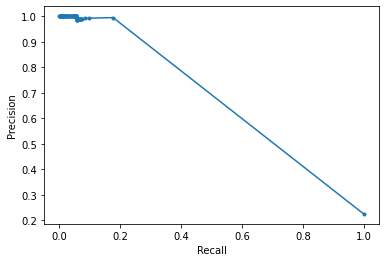

AUC: 0.59
Iteration: 14
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0003 | g_loss: 0.2395 (22.05, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 2.4500
[INFO] Training phase... Elapsed time: 6275 seconds



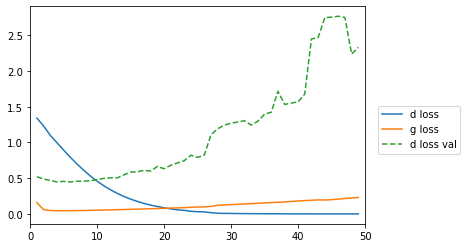

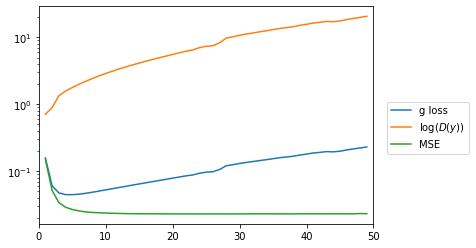

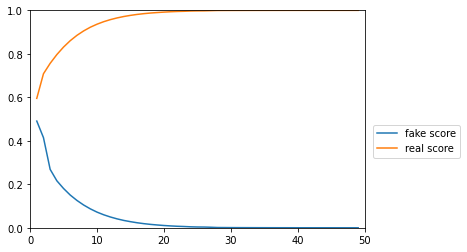

PR AUC: 0.99


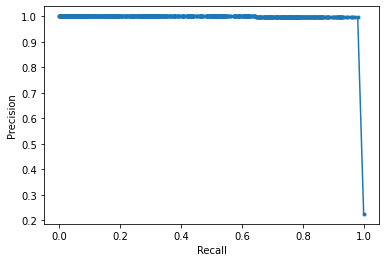

AUC: 0.99
Iteration: 15
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0003 | g_loss: 0.2288 (21.15, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.0299
[INFO] Training phase... Elapsed time: 4314 seconds



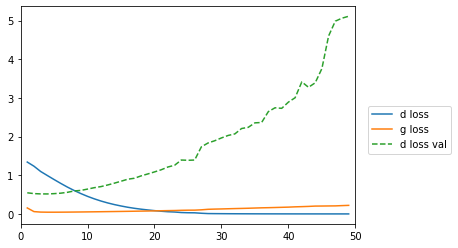

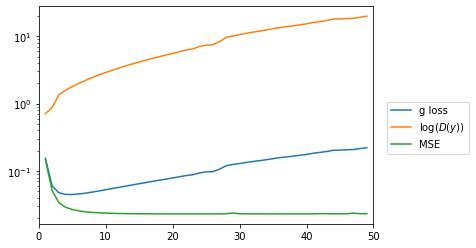

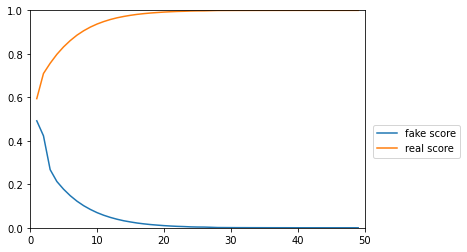

PR AUC: 0.70


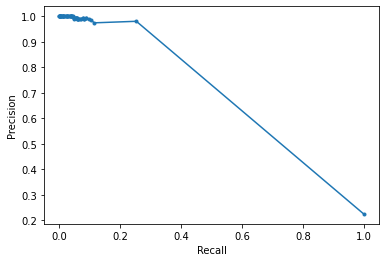

AUC: 0.63
Iteration: 16
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2139 (19.44, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.2372
[INFO] Training phase... Elapsed time: 4875 seconds



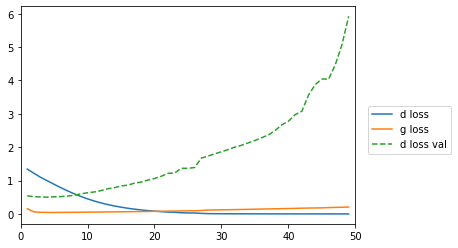

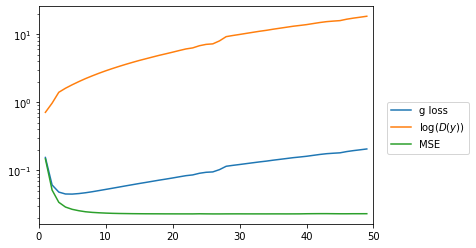

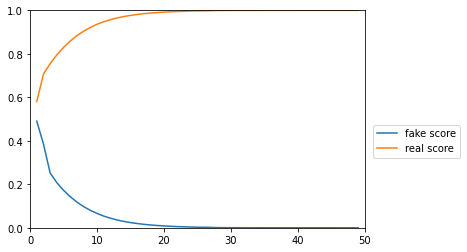

PR AUC: 0.67


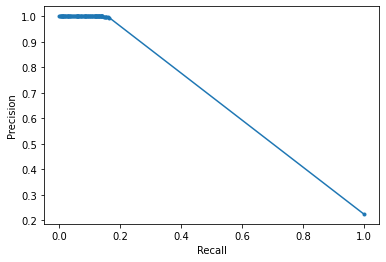

AUC: 0.58
Iteration: 17
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.2123 (19.45, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 5.6613
[INFO] Training phase... Elapsed time: 5257 seconds



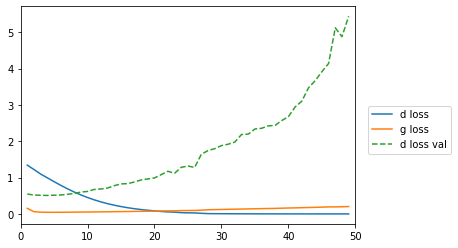

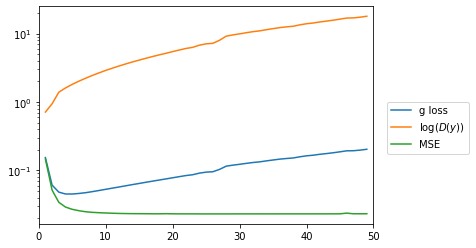

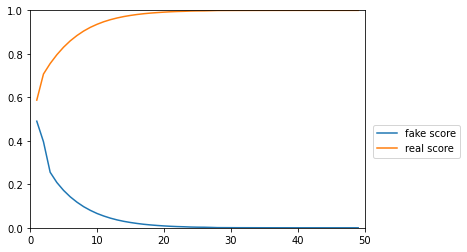

PR AUC: 0.76


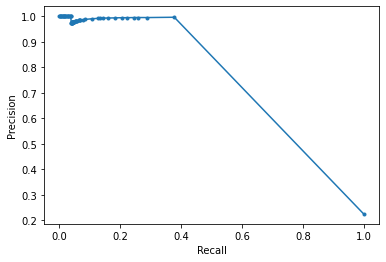

AUC: 0.69
Iteration: 18
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0002 | g_loss: 0.1993 (18.01, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 6.4943
[INFO] Training phase... Elapsed time: 5240 seconds



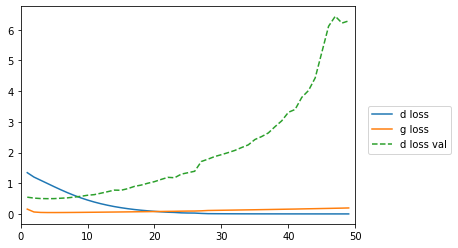

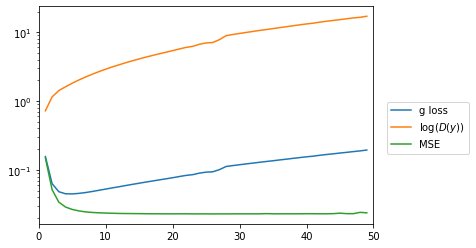

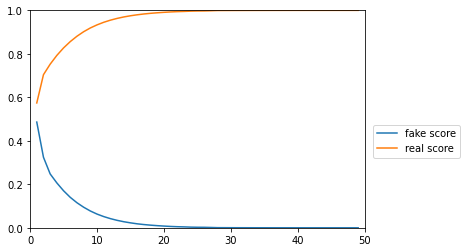

PR AUC: 0.66


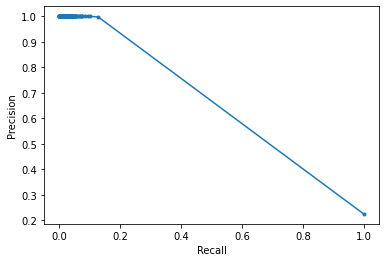

AUC: 0.56
Iteration: 19
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0005 | g_loss: 0.2403 (21.98, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 4.1194
[INFO] Training phase... Elapsed time: 4197 seconds



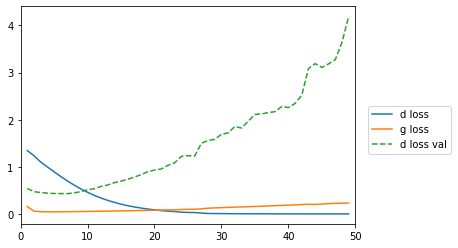

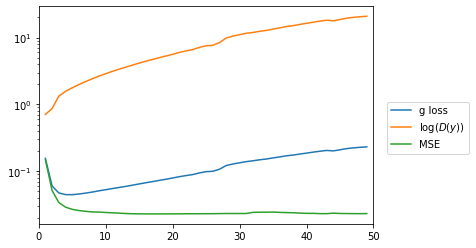

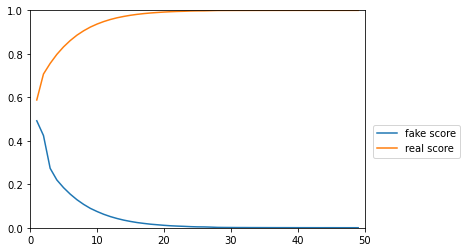

PR AUC: 0.89


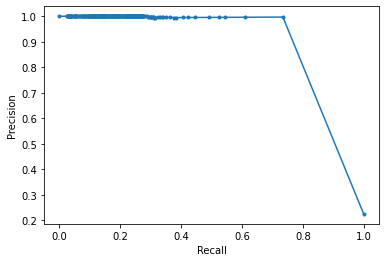

AUC: 0.87
Iteration: 20
[INFO] Starting training phase...
Epoch [ 50/50] | d_loss: 0.0003 | g_loss: 0.2228 (19.98, 0.02) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 4.4760
[INFO] Training phase... Elapsed time: 2774 seconds



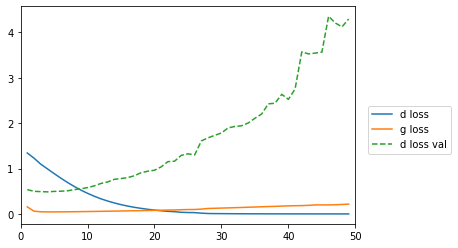

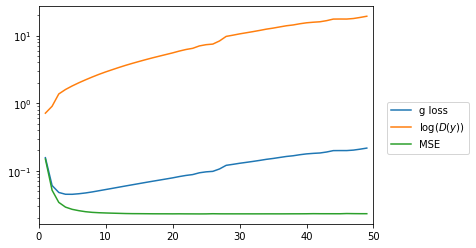

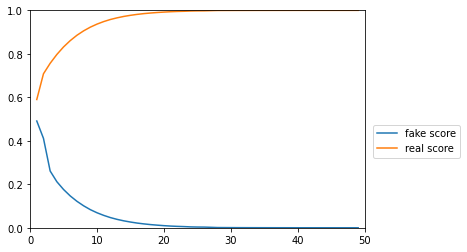

PR AUC: 0.87


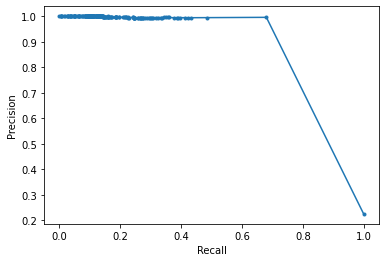

AUC: 0.84


In [6]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CoverType(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = AADNet(device, dataset['selectedColumns'], dataset['discreteCol'], dataset['index'], dataset['x_train'].shape[1])
    
    d_losses, g_losses, rec_losses, bce_losses, real_scores, fake_scores, d_losses_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save models
    NAME_D = f'D_GCN_NOV_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GCN_NOV_{DATASET}_{i}.ckpt'
    
    torch.save(trainer.D.state_dict(), os.path.join(SPACE_MODELS, NAME_D))
    torch.save(trainer.G.state_dict(), os.path.join(SPACE_MODELS, NAME_G))
    
    plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, real_scores, fake_scores, i, DATASET, show = True)
    
    prediction, y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(1-y_true, 1-yP)
    pr = trainer.pr_auc(1-y_true, 1-yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [7]:
meanAUC_PRAUC(auc_list, pr_list, 'GCN_NOV_CoverType', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.794434891124715, 0.7205383002947846, 0.7222343807381971, 0.6004765719287039, 0.727324541227198, 0.7135033615087091, 0.868233354872884, 0.6240941164979087, 0.8951461489889272, 0.730817119419364, 0.5392150375106665, 0.7474675732304816, 0.588262553415563, 0.9899628980979592, 0.625844362932308, 0.582086662215108, 0.6886851146156948, 0.5640138160618245, 0.8669613389157231, 0.8397355176503194]
**************
PR AUC:
[0.8368443787226196, 0.7790643397334444, 0.7816682963615138, 0.6889472516414418, 0.7838263229823101, 0.7773301107653561, 0.8963977569986493, 0.7078859687326906, 0.9153205713368314, 0.7897943925389418, 0.6408009487923929, 0.7921575854095244, 0.6780245107075843, 0.9913369734346749, 0.6994312305261157, 0.6738542992428205, 0.7551897502247998, 0.6609877612310598, 0.894906418901473, 0.8729097328415413]
**************
AUC
0.72 +/- 0.05
95% confidence level, average auc would be between 0.67 and 0.77
**************
PR AUC
0.78 +/- 0.04
95% confidence level, average auc would be b

---